In [1]:
import subprocess
import sys

print("📦 Installing timm...")
subprocess.check_call([sys.executable, "-m", "pip", "install", "timm", "--quiet"])
print("✅ Installation complete!")

import os
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

import warnings
warnings.filterwarnings('ignore')

📦 Installing timm...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.3 MB/s eta 0:00:00


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
libcugraph-cu12 25.6.0 requires libraft-cu12==25.6.*, but you have libraft-cu12 25.2.0 which is incompatible.
pylibcugraph-cu12 25.6.0 requires pylibraft-cu12==25.6.*, but you have pylibraft-cu12 25.2.0 which is incompatible.
pylibcugraph-cu12 25.6.0 requires rmm-cu12==25.6.*, but you have rmm-cu12 25.2.0 which is incompatible.


✅ Installation complete!


/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️  Device: {device}")

# 🔴 GANTI PATH SESUAI DENGANMU
DATASET_PATH = Path("/kaggle/input/iwilldoit/dataset_clean_384-20251130T055651Z-1-001/dataset_clean_384")
OUTPUT_DIR = Path("/kaggle/working/safeface_final")
os.makedirs(OUTPUT_DIR, exist_ok=True)

IMG_SIZE = 384
BATCH_SIZE = 12  # sedikit lebih kecil untuk stabilitas
EPOCHS = 120
WARMUP_EPOCHS = 15
LR_WARMUP = 5e-4
LR_FINETUNE = 1e-5
WEIGHT_DECAY = 1e-4

🖥️  Device: cuda


In [3]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean() if self.reduction == 'mean' else focal_loss.sum()


In [4]:
def get_train_aug():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.08, contrast_limit=0.08, p=0.5),
        A.Resize(IMG_SIZE, IMG_SIZE, interpolation=cv2.INTER_CUBIC),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

def get_val_transform():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE, interpolation=cv2.INTER_CUBIC),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

In [5]:
class FaceDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = plt.imread(self.paths[idx])
        if img.shape[-1] == 4:
            img = img[..., :3]
        elif len(img.shape) == 2:
            img = np.stack([img] * 3, axis=-1)
        if img.dtype == np.float32 or img.dtype == np.float64:
            img = (img * 255).astype(np.uint8)
        if self.transform:
            img = self.transform(image=img)['image']
        return img, self.labels[idx]

In [6]:
classes = sorted([d.name for d in DATASET_PATH.iterdir() if d.is_dir()])
print(f"📁 Total kelas: {len(classes)}")

train_paths, test_paths = [], []
train_labels, test_labels = [], []

for class_idx, class_name in enumerate(classes):
    class_dir = DATASET_PATH / class_name
    img_paths = sorted([p for p in class_dir.glob("*") if p.suffix.lower() in {'.png', '.jpg', '.jpeg'}])
    if len(img_paths) != 4:
        raise ValueError(f"Kelas {class_name} harus punya 4 gambar, punya {len(img_paths)}")
    train_paths.extend([str(p) for p in img_paths[:3]])
    test_paths.append(str(img_paths[3]))
    train_labels.extend([class_idx] * 3)
    test_labels.append(class_idx)

NUM_CLASSES = len(classes)
print(f"✅ Train: {len(train_paths)} | Test: {len(test_paths)}")

📁 Total kelas: 70
✅ Train: 210 | Test: 70


In [7]:
train_dataset = FaceDataset(train_paths, train_labels, get_train_aug())
test_dataset = FaceDataset(test_paths, test_labels, get_val_transform())

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)


In [8]:
print("📥 Loading deit3_small_patch16_384...")
model = timm.create_model('deit3_small_patch16_384', pretrained=True, num_classes=0)
model.head = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(384, NUM_CLASSES)  # deit3_small punya 384 features
)

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
model = model.to(device)

criterion = FocalLoss(alpha=1, gamma=2)

📥 Loading deit3_small_patch16_384...


model.safetensors:   0%|          | 0.00/88.8M [00:00<?, ?B/s]

In [9]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for images, labels in tqdm(loader, desc="Train", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, pred = outputs.max(1)
        total += labels.size(0)
        correct += pred.eq(labels).sum().item()
    return total_loss / len(loader), 100. * correct / total

def validate(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Test", leave=False):
            images = images.to(device)
            outputs = model(images)
            _, pred = outputs.max(1)
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(labels.numpy())
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    return acc, f1, all_preds, all_labels


In [10]:
if hasattr(model, 'module'):
    for p in model.module.parameters(): p.requires_grad = False
    for p in model.module.head.parameters(): p.requires_grad = True
else:
    for p in model.parameters(): p.requires_grad = False
    for p in model.head.parameters(): p.requires_grad = True

optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LR_WARMUP, weight_decay=WEIGHT_DECAY)

print("🔥 Warmup Phase...")
for epoch in range(WARMUP_EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    print(f"Warmup {epoch+1}/{WARMUP_EPOCHS} | Loss: {train_loss:.4f} | Acc: {train_acc:.2f}%")

# --- Fine-tuning: Latih semua ---
for p in model.parameters(): p.requires_grad = True

if hasattr(model, 'module'):
    backbone = [p for n, p in model.module.named_parameters() if 'head' not in n]
    head = model.module.head.parameters()
else:
    backbone = [p for n, p in model.named_parameters() if 'head' not in n]
    head = model.head.parameters()

optimizer = optim.AdamW([
    {'params': backbone, 'lr': LR_FINETUNE},
    {'params': head, 'lr': LR_FINETUNE * 10}
], weight_decay=WEIGHT_DECAY)

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS - WARMUP_EPOCHS, eta_min=1e-7)

# --- Main Training ---
history = {'train_loss': [], 'train_acc': [], 'test_acc': [], 'test_f1': []}
best_f1, patience_counter, patience = 0.0, 0, 25

print("🎯 Main Training...")
for epoch in range(EPOCHS - WARMUP_EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    test_acc, test_f1, _, _ = validate(model, test_loader, device)
    scheduler.step()
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['test_acc'].append(test_acc * 100)
    history['test_f1'].append(test_f1)
    
    if test_f1 > best_f1:
        best_f1 = test_f1
        best_acc = test_acc
        patience_counter = 0
        state_dict = model.module.state_dict() if hasattr(model, 'module') else model.state_dict()
        torch.save({
            'model_state_dict': state_dict,
            'test_f1': test_f1,
            'test_acc': test_acc,
            'classes': classes
        }, OUTPUT_DIR / "final_model.pth")
        print(f"✅ SAVED! Test Acc: {test_acc*100:.2f}% | F1: {test_f1:.4f}")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("⏹️ Early stopping!")
            break


🔥 Warmup Phase...


Warmup 1/15 | Loss: 4.9198 | Acc: 1.47%


Warmup 2/15 | Loss: 4.3278 | Acc: 3.43%


Warmup 3/15 | Loss: 3.8677 | Acc: 5.88%


Warmup 4/15 | Loss: 3.3935 | Acc: 11.27%


Warmup 5/15 | Loss: 3.0655 | Acc: 17.65%


Warmup 6/15 | Loss: 2.7115 | Acc: 30.39%


Warmup 7/15 | Loss: 2.3460 | Acc: 42.65%


Warmup 8/15 | Loss: 2.1110 | Acc: 45.59%


Warmup 9/15 | Loss: 1.8401 | Acc: 53.92%


Warmup 10/15 | Loss: 1.6297 | Acc: 56.86%


Warmup 11/15 | Loss: 1.5007 | Acc: 65.69%


Warmup 12/15 | Loss: 1.1490 | Acc: 75.00%


Warmup 13/15 | Loss: 0.9751 | Acc: 76.96%


Warmup 14/15 | Loss: 0.9097 | Acc: 82.35%


Warmup 15/15 | Loss: 0.9068 | Acc: 80.88%
🎯 Main Training...


✅ SAVED! Test Acc: 54.29% | F1: 0.4738


✅ SAVED! Test Acc: 58.57% | F1: 0.5310


✅ SAVED! Test Acc: 58.57% | F1: 0.5381


✅ SAVED! Test Acc: 58.57% | F1: 0.5438


✅ SAVED! Test Acc: 58.57% | F1: 0.5471


✅ SAVED! Test Acc: 60.00% | F1: 0.5590


✅ SAVED! Test Acc: 61.43% | F1: 0.5619


✅ SAVED! Test Acc: 60.00% | F1: 0.5667


✅ SAVED! Test Acc: 61.43% | F1: 0.5690


✅ SAVED! Test Acc: 61.43% | F1: 0.5690


✅ SAVED! Test Acc: 61.43% | F1: 0.5738


✅ SAVED! Test Acc: 61.43% | F1: 0.5762


✅ SAVED! Test Acc: 61.43% | F1: 0.5786



📊 PER-KELAS ANALYSIS
Top 5 Best Classes:
  Abu Bakar Siddiq Siregar: 1.000
  Ahmad Faqih Hasani: 1.000
  Alfajar: 1.000
  Arkan Hariz Chandrawinata Liem: 1.000
  Bezalel Samuel Manik: 1.000

Top 5 Worst Classes:
  Abraham Ganda Napitu: 0.000
  Alief Fathur Rahman: 0.000
  Bayu Ega Ferdana: 0.000
  Bayu Prameswara Haris: 0.000
  Boy Sandro Sigiro: 0.000

🎯 FINAL RESULTS
Total Classes     : 70
Train Images      : 210
Test Images       : 70
Test Accuracy     : 61.43%
Test F1-Score     : 0.5786

📁 Model & Results saved in: /kaggle/working/safeface_final


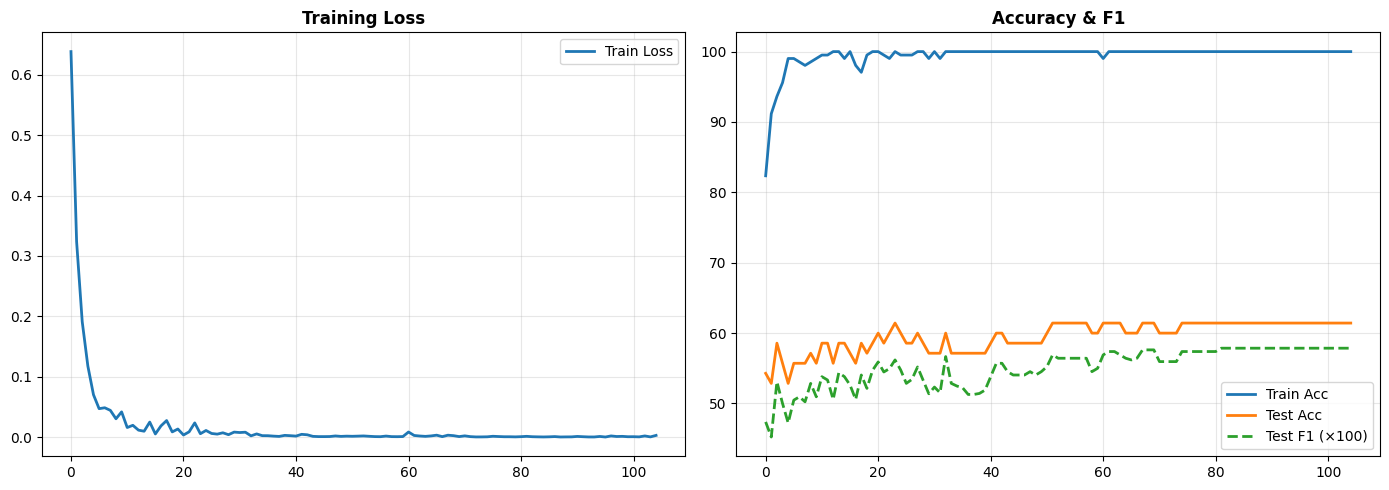

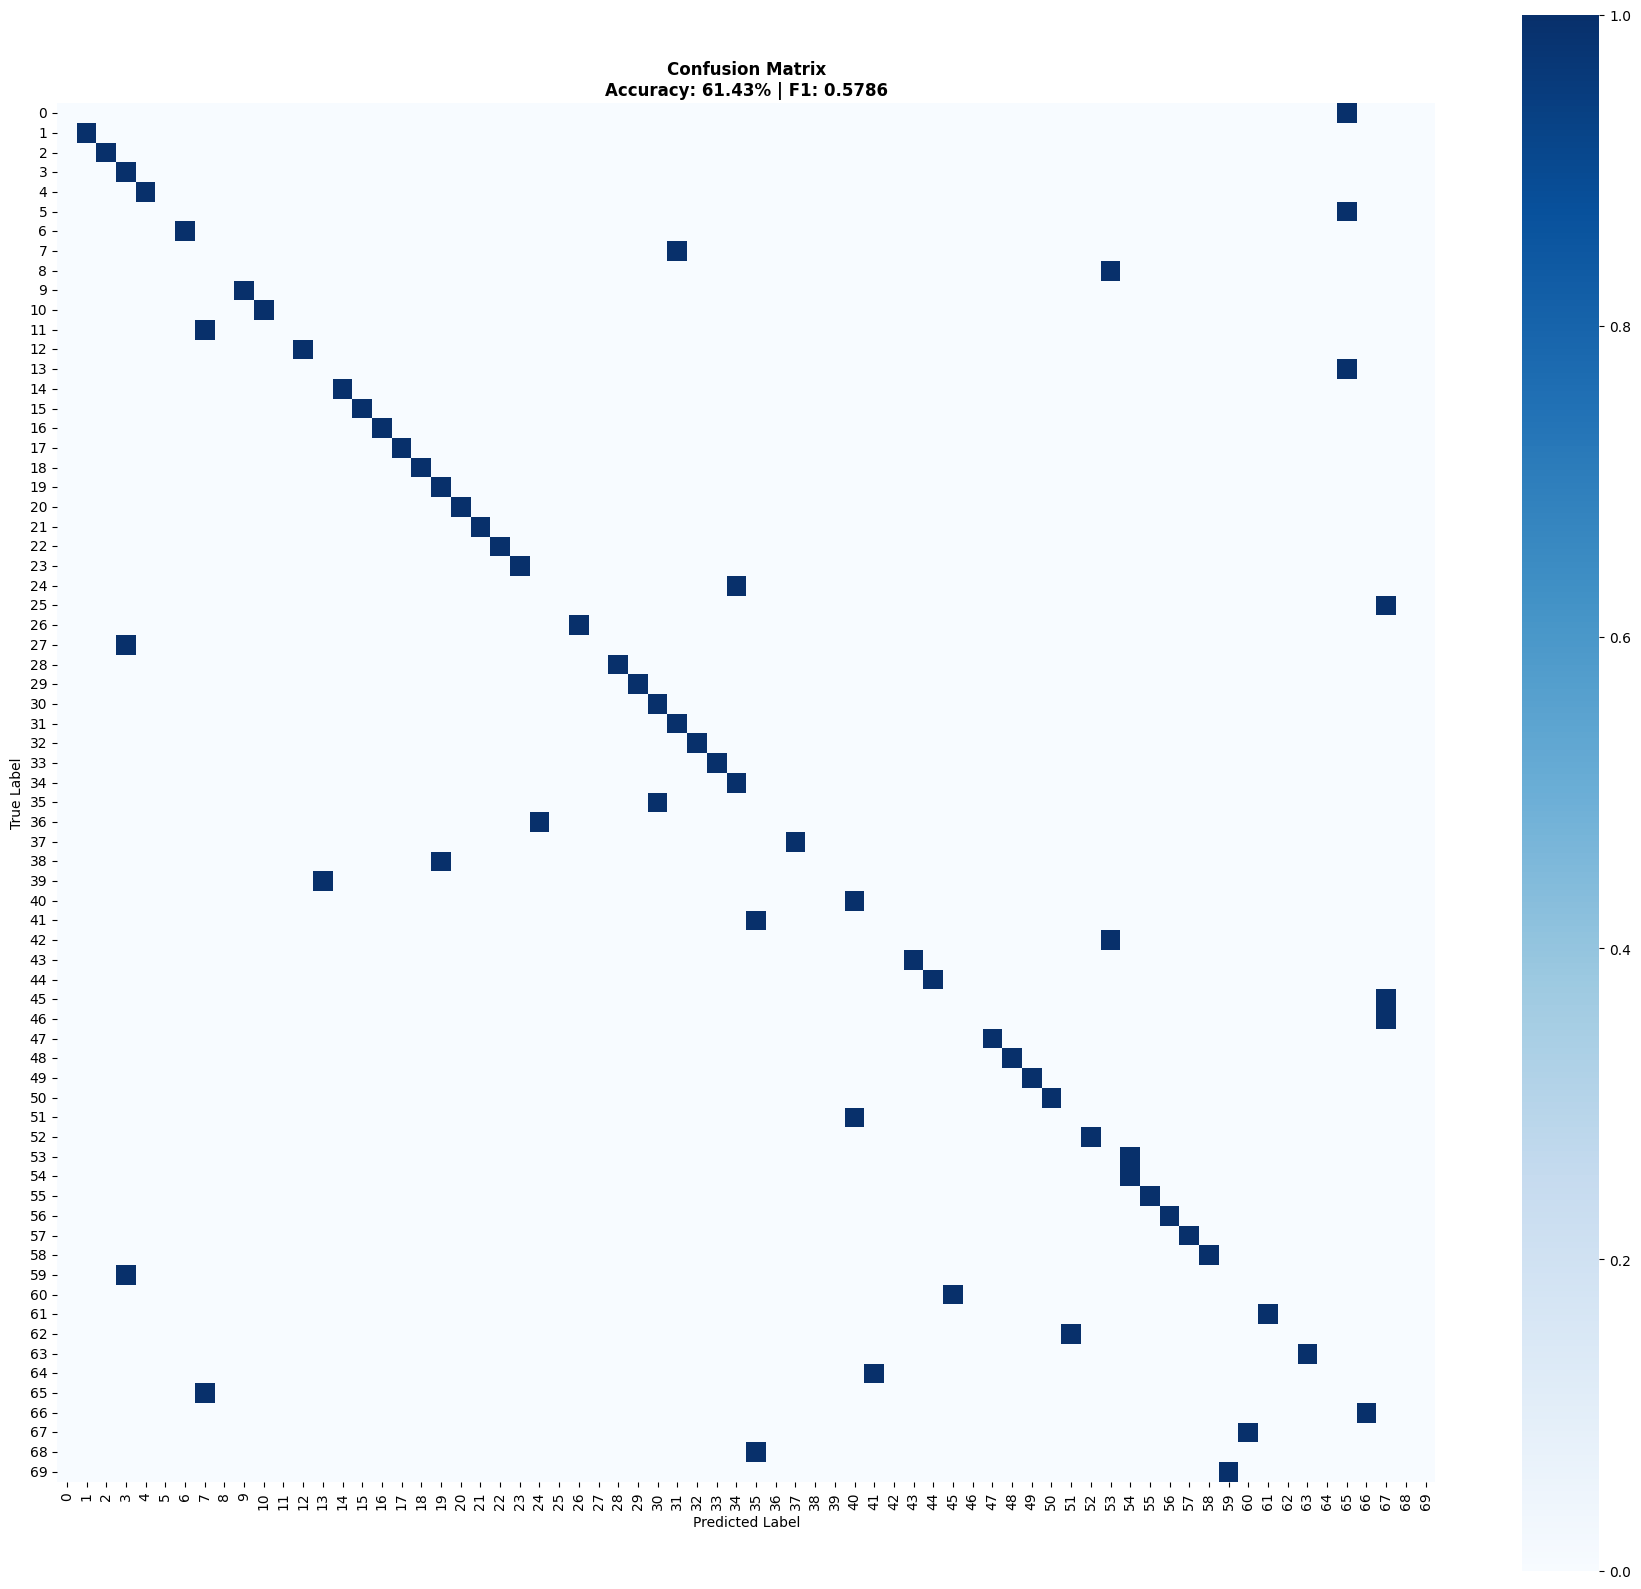

In [11]:
checkpoint = torch.load(OUTPUT_DIR / "final_model.pth", map_location=device, weights_only=False)

if hasattr(model, 'module'):
    model.module.load_state_dict(checkpoint['model_state_dict'])
else:
    model.load_state_dict(checkpoint['model_state_dict'])

final_acc, final_f1, preds, labels = validate(model, test_loader, device)

# Plot history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0].set_title('Training Loss', fontweight='bold')
axes[0].legend(); axes[0].grid(True, alpha=0.3)

axes[1].plot(history['train_acc'], label='Train Acc', linewidth=2)
axes[1].plot(history['test_acc'], label='Test Acc', linewidth=2)
axes[1].plot([f*100 for f in history['test_f1']], label='Test F1 (×100)', linestyle='--', linewidth=2)
axes[1].set_title('Accuracy & F1', fontweight='bold')
axes[1].legend(); axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "training_history.png", dpi=200)

# Confusion Matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(18, 16))
sns.heatmap(cm, annot=False, cmap="Blues", cbar=True, square=True)
plt.title(f"Confusion Matrix\nAccuracy: {final_acc*100:.2f}% | F1: {final_f1:.4f}", fontweight='bold')
plt.ylabel("True Label"); plt.xlabel("Predicted Label")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "confusion_matrix.png", dpi=200)

# Classification Report
report = classification_report(labels, preds, target_names=classes, output_dict=True, zero_division=0)
pd.DataFrame(report).transpose().to_csv(OUTPUT_DIR / "classification_report.csv")

# Per-kelas analysis
class_f1 = {classes[i]: report[classes[i]]['f1-score'] 
            for i in range(len(classes)) if classes[i] in report}

print("\n📊 PER-KELAS ANALYSIS")
print("Top 5 Best Classes:")
for name, score in sorted(class_f1.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(f"  {name}: {score:.3f}")

print("\nTop 5 Worst Classes:")
for name, score in sorted(class_f1.items(), key=lambda x: x[1])[:5]:
    print(f"  {name}: {score:.3f}")

# Final result
print(f"\n{'='*50}")
print("🎯 FINAL RESULTS")
print(f"{'='*50}")
print(f"Total Classes     : {NUM_CLASSES}")
print(f"Train Images      : {len(train_paths)}")
print(f"Test Images       : {len(test_paths)}")
print(f"Test Accuracy     : {final_acc*100:.2f}%")
print(f"Test F1-Score     : {final_f1:.4f}")
print(f"\n📁 Model & Results saved in: {OUTPUT_DIR}")